In [120]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

BASE = "../app/data_pipeline"

features = pd.read_csv(f"{BASE}/features_train.csv")
print(features.shape)
features.head()

(297700, 44)


,target_date,warehouse_id,store_id,sku_id,region,cat_low,actual_order_qty,lag_1,lag_2,lag_4,...,back_to_school,avg_temp_c_ma4,cdd_ma4,hdd_ma4,precip_mm_ma4,himart_sales_index_ma4,holiday_index_ma4,marketing_score_ma4,y,split
0,2016-02-29,1,1,AC-CAR-16P-2024,본사창고,에어컨,60,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,60.0,train
1,2016-03-07,1,1,AC-CAR-16P-2024,본사창고,에어컨,0,60.0,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,train
2,2016-03-14,1,1,AC-CAR-16P-2024,본사창고,에어컨,0,0.0,60.0,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,train
3,2016-03-21,1,1,AC-CAR-16P-2024,본사창고,에어컨,0,0.0,0.0,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,train
4,2016-03-28,1,1,AC-CAR-16P-2024,본사창고,에어컨,0,0.0,0.0,60.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,train


In [121]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matyplotlib -rf

Sudo媛� �씠 而댄벂�꽣�뿉�꽌 �궗�슜�븯吏� �븡�룄濡� �꽕�젙�릺�뼱 �엳�뒿�땲�떎. �궗�슜�븯�룄濡� �꽕�젙�븯�젮硫� �쑝濡� �씠�룞�븯�꽭�슂. ]8;;ms-settings:developers\Developer Settings page]8;;\ �꽕�젙 �빋�쓽
Sudo媛� �씠 而댄벂�꽣�뿉�꽌 �궗�슜�븯吏� �븡�룄濡� �꽕�젙�릺�뼱 �엳�뒿�땲�떎. �궗�슜�븯�룄濡� �꽕�젙�븯�젮硫� �쑝濡� �씠�룞�븯�꽭�슂. ]8;;ms-settings:developers\Developer Settings page]8;;\ �꽕�젙 �빋�쓽
'rm'은(는) 내부 또는 외부 명령, 실행할 수 있는 프로그램, 또는
배치 파일이 아닙니다.


In [122]:
plt.rc('font', family='NanumBarunGothic')

# EDA
## 1. 타겟 분포 확인

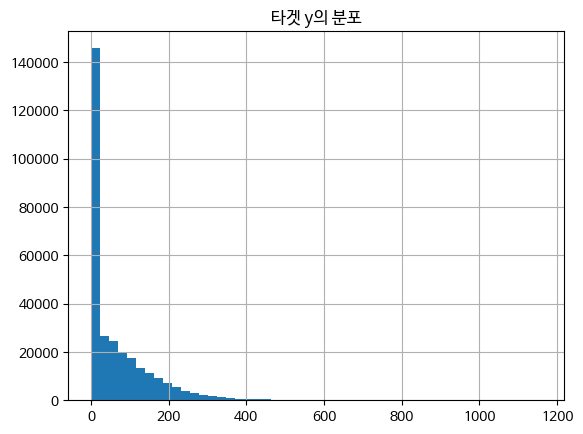

In [123]:
features["y"].hist(bins=50)
plt.title("타겟 y의 분포")
plt.show()

## 2. 기본 통계

In [124]:
features["y"].describe()

count    297700.000000
mean         65.241454
std          97.505835
min           0.000000
25%           0.000000
50%          27.000000
75%         101.000000
max        1161.000000
Name: y, dtype: float64

median(50%) = 0, 75% = 89, max = 1098  
-> 거의 절반 이상의 주차가 판매 0. 나머지는 오른쪽으로 긴 꼬리가 있는 heavy right tail 분포  
: 0이 엄청 많고 일부 SKU가 크게 팔리는 구조. 전형적인 리테일/재고 데이터 모습  
: MAE 기준으로 보면 큰 수요가 있는 주차가 훨씬 더 영향을 많이 줌

## 3. 카테고리/sku별 판매량

In [125]:
features.columns.tolist()

['target_date',
 'warehouse_id',
 'store_id',
 'sku_id',
 'region',
 'cat_low',
 'actual_order_qty',
 'lag_1',
 'lag_2',
 'lag_4',
 'lag_8',
 'lag_12',
 'ma_4',
 'ma_8',
 'ma_12',
 'share_norm',
 'promo_flag',
 'promo_flag_prev',
 'year',
 'weekofyear',
 'month',
 'sin_week',
 'cos_week',
 'avg_temp_c',
 'cdd',
 'hdd',
 'precip_mm',
 'heat_wave',
 'cold_wave',
 'himart_sales_krw',
 'himart_sales_index',
 'holiday_index',
 'marketing_score',
 'seasonal_peak',
 'back_to_school',
 'avg_temp_c_ma4',
 'cdd_ma4',
 'hdd_ma4',
 'precip_mm_ma4',
 'himart_sales_index_ma4',
 'holiday_index_ma4',
 'marketing_score_ma4',
 'y',
 'split']

In [126]:
import pandas as pd
BASE = "../app/data_pipeline"
sku = pd.read_csv(f"{BASE}/sku_catalog.csv")

sku = sku[['sku_id', 'cat_low']] 

features_merged = features.merge(sku, on='sku_id', how='left')
features_merged.groupby("cat_low")["y"].sum().sort_values(ascending=False).head(20)


KeyError: 'cat_low'

어떤 카테고리/상품이 수요예측에서 중요한지.  

## 4. 날짜·주차별 패턴

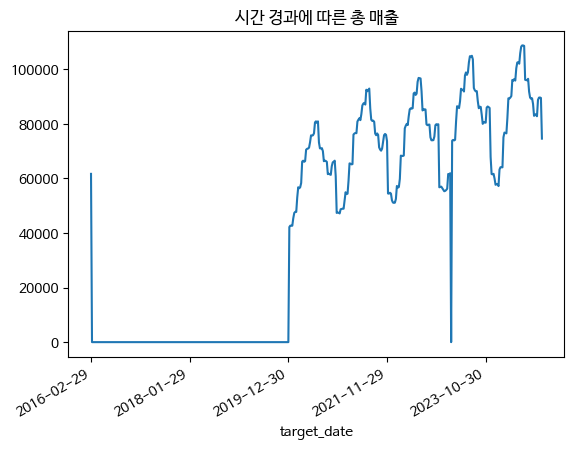

In [127]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
features.groupby("target_date")["y"].sum().plot(ax=ax)
plt.title("시간 경과에 따른 총 매출")

fig.autofmt_xdate() 
plt.show()


연도별로 계절 패턴이 보임  
-> 주간 수요예측 모델이 시즌성을 잘 잡아야함

## 5. 외부 요인 영향

In [128]:
cols = ["avg_temp_c", "holiday_index", "promo_flag"]  
features[cols + ["y"]].corr()


,avg_temp_c,holiday_index,promo_flag,y
avg_temp_c,1.000000,0.041854,0.388865,0.464648
holiday_index,0.041854,1.000000,0.158080,0.098661
promo_flag,0.388865,0.158080,1.000000,0.671029
y,0.464648,0.098661,0.671029,1.000000


프로모션, 기온은 수요에 큰 영향 줌. -> 피쳐로 유지  
완벽히 선형 관계는 아님. -> 트리계열 모델 사용해서 이런 패턴 잡아주기   
상관계수 낮아도 트리 기반 모델은 비선형 관계 잘 잡음

## 6.타깃 로그 변환 분포 확인

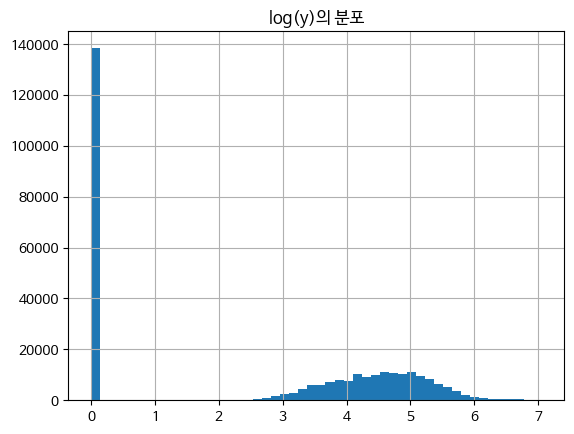

In [129]:
features["log_y"] = np.log1p(features["y"])
features["log_y"].hist(bins=50)
plt.title("log(y)의 분포")
plt.show()

0인 값이 많음 == 판매가 0인 주차가 많음.  
로그를 써서 큰 값 쪽 꼬리는 완화했지만 0값에 대해서는 따로 접근해야할수도 있음 

## 7. Lag Feature 상관분석  
Lag : 시차 변수. 과거 시점의 값을 그대로 가져와서 새로운 변수로 사용하는 것.

In [130]:
lag_cols = ["lag_1","lag_2","lag_4","lag_8","lag_12"]
features[lag_cols + ["y"]].corr()


,lag_1,lag_2,lag_4,lag_8,lag_12,y
lag_1,1.000000,0.982542,0.966382,0.932422,0.894199,0.982466
lag_2,0.982542,1.000000,0.974431,0.940950,0.903601,0.974418
lag_4,0.966382,0.974431,1.000000,0.958446,0.923208,0.958690
lag_8,0.932422,0.940950,0.958446,1.000000,0.958157,0.923969
lag_12,0.894199,0.903601,0.923208,0.958157,1.000000,0.885032
y,0.982466,0.974418,0.958690,0.923969,0.885032,1.000000


## 8. MA Feature 상관분석  
MA : 이동 평균. 일정 기간 동안의 평균값을 굴러가며 계산하는 것.

In [131]:
ma_cols = ["ma_4","ma_8","ma_12"]
features[ma_cols + ["y"]].corr()

,ma_4,ma_8,ma_12,y
ma_4,1.000000,0.993684,0.983721,0.977543
ma_8,0.993684,1.000000,0.995899,0.966573
ma_12,0.983721,0.995899,1.000000,0.954259
y,0.977543,0.966573,0.954259,1.000000


lag_* 와 y 상관이 0.93~0.98 수준, ma_*도 비슷하게 높음  
-> 바로 전/이전 주 수요가 현재 주 수요를 거의 직접적으로 설명.

## 9. 외부 요인 히트맵

In [132]:
!pip install seaborn


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


<Axes: >

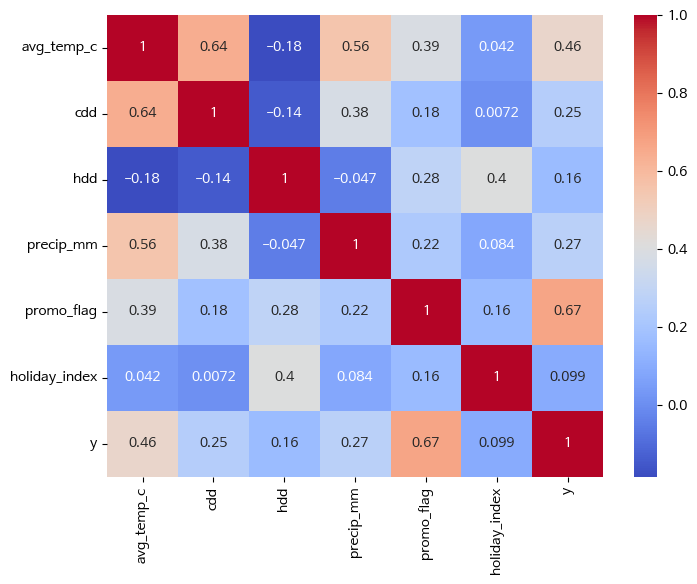

In [133]:
import seaborn as sns
plt.figure(figsize=(8,6))
cols = ["avg_temp_c","cdd","hdd","precip_mm","promo_flag","holiday_index"]
sns.heatmap(features[cols + ["y"]].corr(), annot=True, cmap="coolwarm")

## 10. SKU Sales profile

In [134]:
features.groupby("sku_id")["y"].sum().sort_values(ascending=False).head(20)

sku_id
MIX-CUI-HAND-2024         1212257.0
WAT-APL-AW-41-2024         765246.0
WAT-SAM-GAL-45-2024        754243.0
TOA-PHI-2S-2024            634308.0
TOA-BRN-2S-2024            621107.0
DES-HP-STD-2024            538368.0
MW-SAM-30L-2024            532856.0
DES-LEN-THINK-2024         524512.0
DES-SAM-STD-2024           524292.0
DW-SAM-12P-2024            521876.0
DW-LG-12P-2024             477474.0
MW-LG-25L-2024             469610.0
AIR-LG-PURI-58-2024        433783.0
COF-BRV-SEMI-2024          425843.0
AC-LG-STAND-18P-2024       421850.0
COF-NES-CAPS-2024          417065.0
OV-LG-70L-2024             414725.0
COF-DEL-AUTO-2024          412573.0
NBK-SAM-GALAXY-15-2024     358804.0
NBK-LEN-IDEA-15-2023       351943.0
Name: y, dtype: float64

## 11. Feature Importance
데이터 일부만 이용해서 대략적인 feature 영향도 먼저 확인  
LightGBM로 미리 확인

In [135]:
from lightgbm import LGBMRegressor
train = features[features["split"] == "train"].copy()

y = train["y"]

ignore = [
    "warehouse_id", "store_id", "sku_id", "region",
    "target_date", "split", "y",
]

X = train.drop(columns=ignore, errors="ignore")

numeric_cols = X.select_dtypes(include=["number", "bool"]).columns
X = X[numeric_cols]

from lightgbm import LGBMRegressor

model = LGBMRegressor(random_state=42)
model.fit(X, y)

importances = (
    pd.Series(model.feature_importances_, index=X.columns)
      .sort_values(ascending=False)
)
importances.head(20)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.083623 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4483
[LightGBM] [Info] Number of data points in the train set: 297700, number of used features: 37
[LightGBM] [Info] Start training from score 65.241454


actual_order_qty          1240
lag_12                     154
lag_8                      130
precip_mm_ma4              125
lag_1                      125
marketing_score_ma4        124
lag_4                      117
precip_mm                  117
lag_2                      106
marketing_score             86
weekofyear                  79
avg_temp_c                  71
avg_temp_c_ma4              58
sin_week                    57
himart_sales_index_ma4      51
share_norm                  48
himart_sales_krw            39
ma_4                        39
year                        36
cos_week                    32
dtype: int32

## 12. SKU별 수요 패턴 시각화
SKU마다 수요 패턴이 크게 다를 수 있으므로(시즌형, 안정형, 변동 폭주형 등),     
샘플 SKU를 몇 개 골라서 수요 변화 추이를 확인   
-> SKU별 이질성을 얼마나 잘 학습해야 하는지 판단하는 데 도움

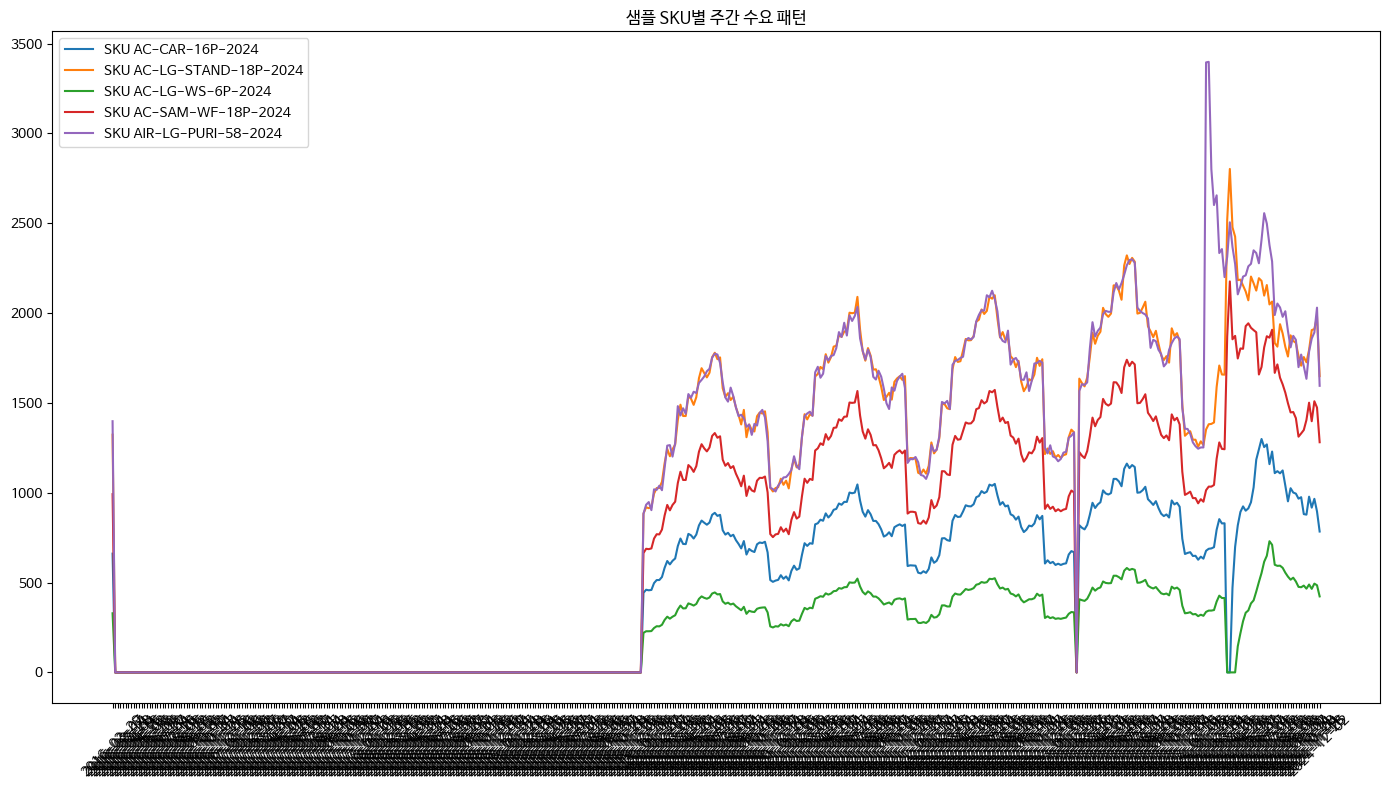

In [136]:
# 임의 SKU 5개 샘플 추출
sample_skus = features["sku_id"].dropna().unique()[:5]

plt.figure(figsize=(14, 8))
for sku in sample_skus:
    subset = features[(features["sku_id"] == sku) & (features["split"] == "train")]

    subset_group = subset.groupby("target_date")["y"].sum()

    plt.plot(subset_group.index, subset_group.values, label=f"SKU {sku}")

plt.title("샘플 SKU별 주간 수요 패턴")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## 13. Lag 피처 vs Target Cross-Correlation
lag 값이 몇 주까지 유효한지 확인 -> lag 범위 확장/축소 근거 제공

In [137]:
!pip install statsmodels


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


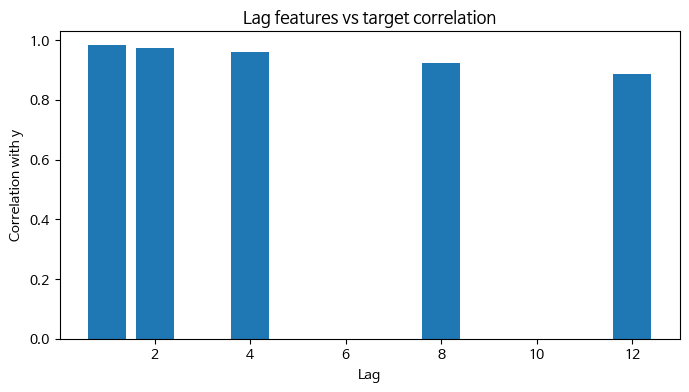

In [138]:
from statsmodels.tsa.stattools import ccf

train = features[features["split"] == "train"].copy()

lags = [1, 2, 4, 8, 12]

corrs = []
for lag in lags:
    corr = train["y"].corr(train[f"lag_{lag}"])
    corrs.append(corr)

plt.figure(figsize=(8, 4))
plt.bar(lags, corrs)
plt.xlabel("Lag")
plt.ylabel("Correlation with y")
plt.title("Lag features vs target correlation")
plt.show()


## 14. 프로모션/휴일 효과 Boxplot
프로모션·휴일 등의 외부 요인이 실제로 수요량을 변화시키는지 유의한 근거 확보

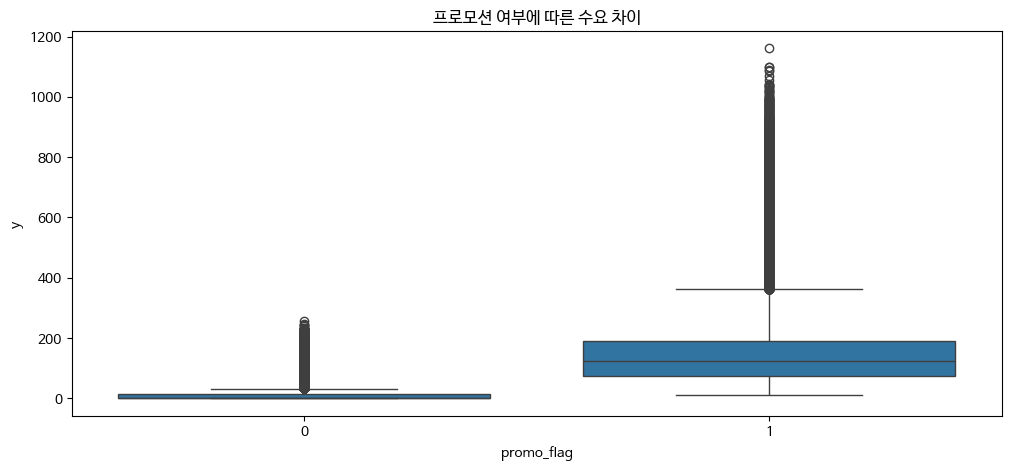

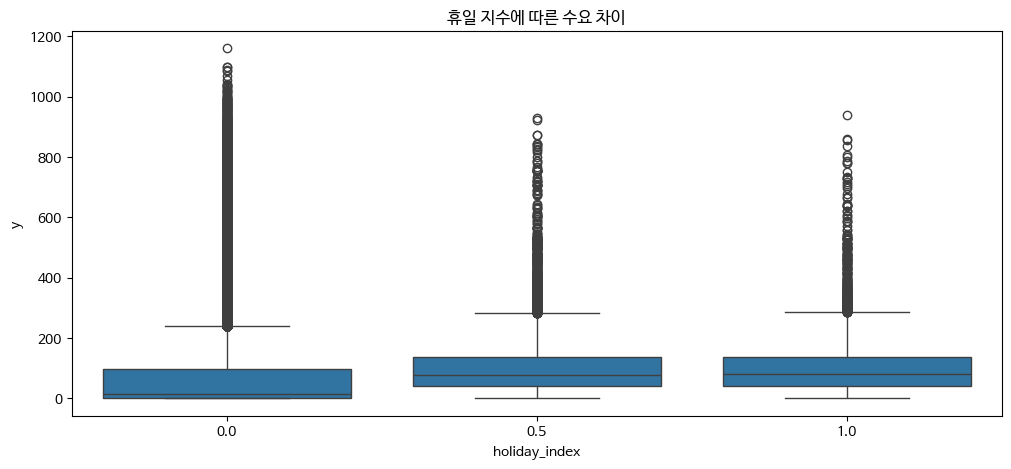

In [139]:
import seaborn as sns

plt.figure(figsize=(12, 5))
sns.boxplot(x="promo_flag", y="y", data=train)
plt.title("프로모션 여부에 따른 수요 차이")
plt.show()

plt.figure(figsize=(12, 5))
sns.boxplot(x="holiday_index", y="y", data=train)
plt.title("휴일 지수에 따른 수요 차이")
plt.show()


## 15. 결측치 히트맵
외부요인/lag/MA 피처 중 결측치 비율이 높은 항목이 있는지 확인

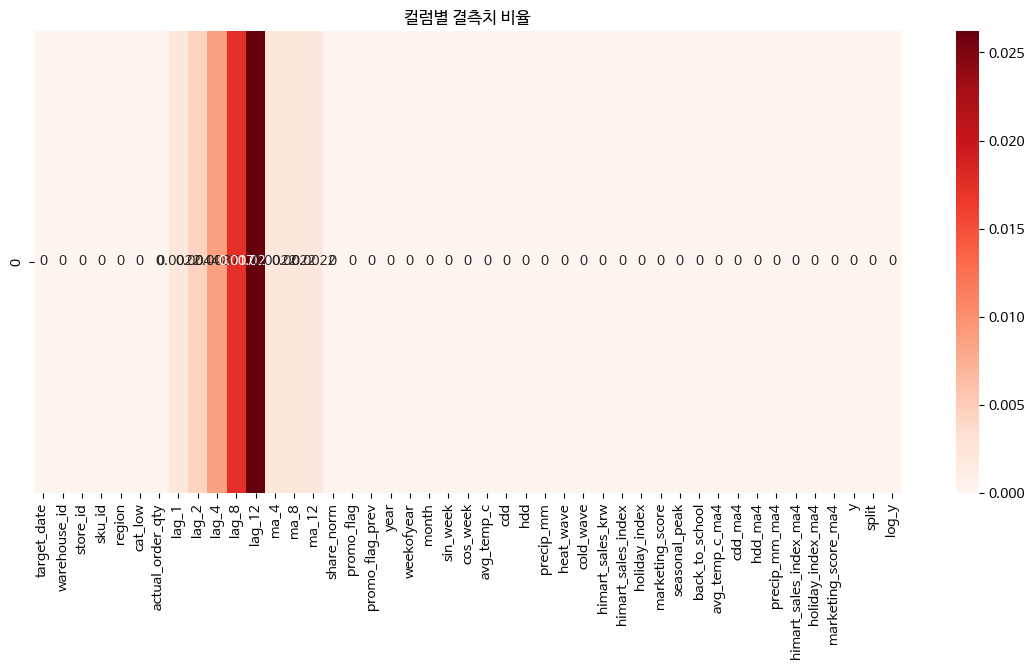

In [140]:
import seaborn as sns

plt.figure(figsize=(14, 6))
sns.heatmap(features.isnull().mean().to_frame().T, cmap="Reds", annot=True)
plt.title("컬럼별 결측치 비율")
plt.show()


라그/이동평균은 초기 몇 주는 값이 없어서 NaN 이 나옴.  
나머지 컬럼은 원래부터 결측이 거의 없거나 코드 상에서 이미 fillna(0) 등으로 처리한 뒤라서 결측 비율이 0으로 나옴

## 16. 카테고리별 평균 수요 비교
카테고리별 기본 수요 수준 차이를 확인 -> target encoding/one-hot 전략 근거

In [141]:
from pathlib import Path
import pandas as pd

BASE = Path("../app/data_pipeline").resolve()

print(">>> LOADING FROM:", BASE / "features_all.csv")
df = pd.read_csv(BASE / "features_all.csv")

print(df.shape)
df.head()


>>> LOADING FROM: C:\Users\chosw\ORDER101_AI\be18-fin-SYNERGY-ORDER101\python-server\app\data_pipeline\features_all.csv
(300300, 44)


,target_date,warehouse_id,store_id,sku_id,region,cat_low,actual_order_qty,lag_1,lag_2,lag_4,...,back_to_school,avg_temp_c_ma4,cdd_ma4,hdd_ma4,precip_mm_ma4,himart_sales_index_ma4,holiday_index_ma4,marketing_score_ma4,y,split
0,2016-02-29,1,1,AC-CAR-16P-2024,본사창고,에어컨,60,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,60.0,train
1,2016-03-07,1,1,AC-CAR-16P-2024,본사창고,에어컨,0,60.0,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,train
2,2016-03-14,1,1,AC-CAR-16P-2024,본사창고,에어컨,0,0.0,60.0,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,train
3,2016-03-21,1,1,AC-CAR-16P-2024,본사창고,에어컨,0,0.0,0.0,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,train
4,2016-03-28,1,1,AC-CAR-16P-2024,본사창고,에어컨,0,0.0,0.0,60.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,train


In [142]:
# 전체 데이터
features = df.copy()

# 학습용(숫자 전용) 데이터
train = features[features["split"] == "train"].copy()
numeric_cols = train.select_dtypes(include=["number", "bool"]).columns
train_numeric = train[numeric_cols]


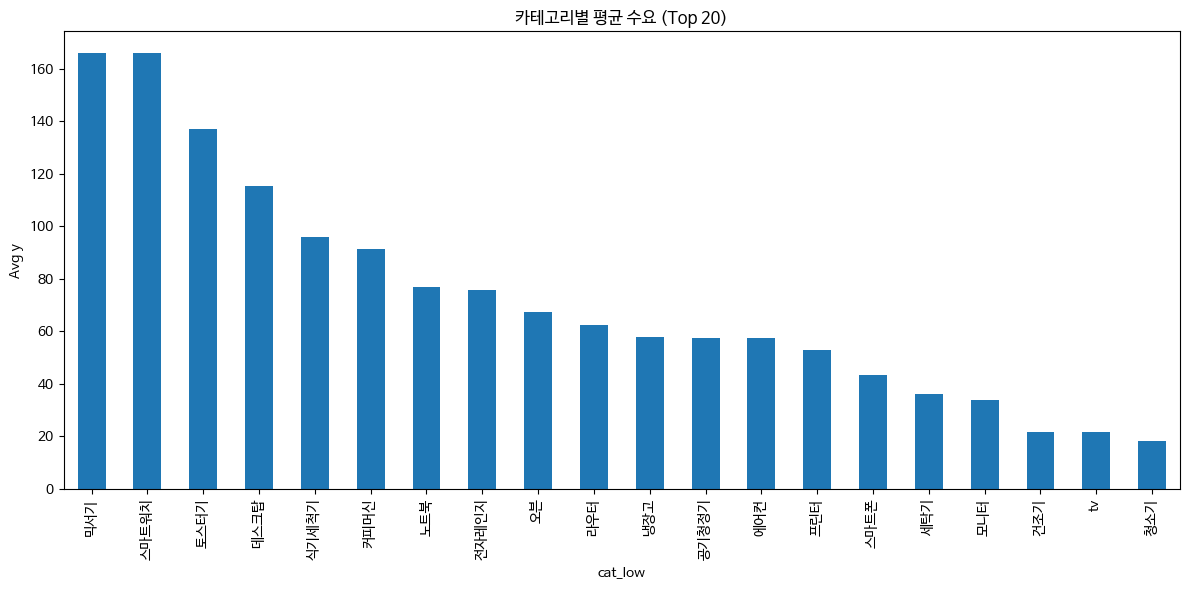

In [143]:
train_cat = features[features["split"] == "train"].copy()

cat_mean = (
    train_cat
      .groupby("cat_low")["y"]
      .mean()
      .sort_values(ascending=False)
)

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
cat_mean.head(20).plot(kind="bar")
plt.title("카테고리별 평균 수요 (Top 20)")
plt.ylabel("Avg y")
plt.tight_layout()
plt.show()


In [144]:
features.columns


Index(['target_date', 'warehouse_id', 'store_id', 'sku_id', 'region',
       'cat_low', 'actual_order_qty', 'lag_1', 'lag_2', 'lag_4', 'lag_8',
       'lag_12', 'ma_4', 'ma_8', 'ma_12', 'share_norm', 'promo_flag',
       'promo_flag_prev', 'year', 'weekofyear', 'month', 'sin_week',
       'cos_week', 'avg_temp_c', 'cdd', 'hdd', 'precip_mm', 'heat_wave',
       'cold_wave', 'himart_sales_krw', 'himart_sales_index', 'holiday_index',
       'marketing_score', 'seasonal_peak', 'back_to_school', 'avg_temp_c_ma4',
       'cdd_ma4', 'hdd_ma4', 'precip_mm_ma4', 'himart_sales_index_ma4',
       'holiday_index_ma4', 'marketing_score_ma4', 'y', 'split'],
      dtype='object')

In [145]:
BASE = "../app/data_pipeline"

train = pd.read_csv(f"{BASE}/features_train.csv")
test  = pd.read_csv(f"{BASE}/features_test.csv")

train["split"] = "train"
test["split"]  = "test"

features = pd.concat([train, test], ignore_index=True)

print("train:", train.shape, "test:", test.shape, "all:", features.shape)
features.head()

train: (297700, 44) test: (2600, 44) all: (300300, 44)


,target_date,warehouse_id,store_id,sku_id,region,cat_low,actual_order_qty,lag_1,lag_2,lag_4,...,back_to_school,avg_temp_c_ma4,cdd_ma4,hdd_ma4,precip_mm_ma4,himart_sales_index_ma4,holiday_index_ma4,marketing_score_ma4,y,split
0,2016-02-29,1,1,AC-CAR-16P-2024,본사창고,에어컨,60,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,60.0,train
1,2016-03-07,1,1,AC-CAR-16P-2024,본사창고,에어컨,0,60.0,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,train
2,2016-03-14,1,1,AC-CAR-16P-2024,본사창고,에어컨,0,0.0,60.0,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,train
3,2016-03-21,1,1,AC-CAR-16P-2024,본사창고,에어컨,0,0.0,0.0,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,train
4,2016-03-28,1,1,AC-CAR-16P-2024,본사창고,에어컨,0,0.0,0.0,60.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,train


In [146]:
train = features[features["split"] == "train"].copy()
test  = features[features["split"] == "test"].copy()

ignore = ["warehouse_id","store_id","sku_id","region","target_date","split","y"]
X_train = train.drop(columns=ignore, errors="ignore")
X_test  = test.drop(columns=ignore, errors="ignore")

num_cols = X_train.select_dtypes(include=["number","bool"]).columns
X_train = X_train[num_cols]
X_test  = X_test[num_cols]

y_train = train["y"]
y_test  = test["y"]


In [147]:
print("train:", train.shape, "test:", test.shape, "all:", features.shape)

train: (297700, 44) test: (2600, 44) all: (300300, 44)


# Baseline Modeling
## 1. Baseline MAE

In [148]:
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error

train = features[features["split"] == "train"].copy()
test  = features[features["split"] == "test"].copy()

ignore = [
    "warehouse_id", "store_id", "sku_id", "region",
    "target_date", "split", "y",
]

X_train = train.drop(columns=ignore, errors="ignore")
X_test  = test.drop(columns=ignore, errors="ignore")

num_cols = X_train.select_dtypes(include=["number", "bool"]).columns
X_train = X_train[num_cols]
X_test  = X_test[num_cols]

y_train = train["y"].astype(float)
y_test  = test["y"].astype(float)

print("X_train:", X_train.shape, "X_test:", X_test.shape)

model = LGBMRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=-1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
)

model.fit(X_train, y_train)

pred = model.predict(X_test)
mae  = mean_absolute_error(y_test, pred)
print("Baseline MAE:", mae)


X_train: (297700, 36) X_test: (2600, 36)
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.055939 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4228
[LightGBM] [Info] Number of data points in the train set: 297700, number of used features: 36
[LightGBM] [Info] Start training from score 65.241454
Baseline MAE: 0.47267101496362113


## 2. importances

In [149]:
importances = (
    pd.Series(model.feature_importances_, index=X_train.columns)
      .sort_values(ascending=False)
)
importances.head(30)


actual_order_qty          3622
lag_1                     2384
ma_4                      1249
lag_2                     1136
share_norm                 906
lag_12                     559
lag_4                      547
lag_8                      479
precip_mm                  429
weekofyear                 414
marketing_score_ma4        351
precip_mm_ma4              332
marketing_score            316
ma_8                       297
avg_temp_c                 285
avg_temp_c_ma4             212
sin_week                   200
cos_week                   163
ma_12                      161
month                      148
himart_sales_index_ma4     139
himart_sales_krw           115
cdd_ma4                    102
hdd_ma4                     99
hdd                         87
year                        79
cdd                         65
promo_flag_prev             30
himart_sales_index          28
back_to_school              19
dtype: int32

## 3. log 변환 모델

In [ ]:
y_train_log = np.log1p(y_train)

model_log = LGBMRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=-1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
)

model_log.fit(X_train, y_train_log)

pred_log = model_log.predict(X_test)
pred_log_to_y = np.expm1(pred_log)

mae_log = mean_absolute_error(y_test, pred_log_to_y)
print("MAE (log target):", mae_log)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.084098 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4228
[LightGBM] [Info] Number of data points in the train set: 297700, number of used features: 36
[LightGBM] [Info] Start training from score 2.420574
